# Motivation

Statistically prove that drought has occured in year 2018 for xanten area by showing relationship between rise in temperature with drop in NDVI

This python code also covers correaltion analysis of QGIS mean with average temperature and Cummulative preciptaion 

# Steps to be followed for analysis

 1) Read DWD CDC Time Series Temperature <br />
 2) Merge with Station Description of Xanten <br />
 3) Filtering data of interested time range <br />
 4) Temperature analysis over Time range <br />
 5) Save data from time series analysis <br />
 6) correlation of Qgis with average temperature and cumulative preciptation <br />
 7) find confidence interval for temperature data


# Prerequisite
QGIS file with mean NDVI data for 9 station found in this analysis

The file can be found in following link:

However, if the programmer doesn't upload the excel file, the below cell will use default data obtained while developing the report

## FTP Connection

### Connection Parameters

In [67]:
server = "opendata.dwd.de"
user   = "anonymous"
passwd = ""

### FTP Directory Definition and Station Description Filename Pattern

In [68]:
# The topic of interest.
# topic_dir = "/hourly/precipitation/recent/"
topic_dir = "/daily/kl/historical/"

# This is the search pattern common to ALL station description file names 
station_desc_pattern = "_Beschreibung_Stationen.txt"

# Below this directory tree node all climate data are stored.
ftp_climate_data_dir = "/climate_environment/CDC/observations_germany/climate/"
ftp_dir =  ftp_climate_data_dir + topic_dir

### Local Directories

In [4]:
local_ftp_dir         = "data/original/DWD/"      # Local directory to store local ftp data copies, the local data source or input data. 
local_ftp_station_dir = local_ftp_dir + topic_dir # Local directory where local station info is located
local_ftp_ts_dir      = local_ftp_dir + topic_dir # Local directory where time series downloaded from ftp are located

local_generated_dir   = "data/generated/DWD/" # The generated of derived data in contrast to local_ftp_dir
local_station_dir     = local_generated_dir + topic_dir # Derived station data, i.e. the CSV file
local_ts_merged_dir   = local_generated_dir + topic_dir # Parallel merged time series, wide data frame with one TS per column
local_ts_appended_dir = local_generated_dir + topic_dir # Serially appended time series, long data frame for QGIS TimeManager Plugin

In [5]:
print(local_ftp_dir)
print(local_ftp_station_dir)
print(local_ftp_ts_dir)
print()
print(local_generated_dir)
print(local_station_dir)
print(local_ts_merged_dir)
print(local_ts_appended_dir)

data/original/DWD/
data/original/DWD//daily/kl/historical/
data/original/DWD//daily/kl/historical/

data/generated/DWD/
data/generated/DWD//daily/kl/historical/
data/generated/DWD//daily/kl/historical/
data/generated/DWD//daily/kl/historical/


In [6]:
import os
os.makedirs(local_ftp_dir,exist_ok = True) # it does not complain if the dir already exists.
os.makedirs(local_ftp_station_dir,exist_ok = True)
os.makedirs(local_ftp_ts_dir,exist_ok = True)

os.makedirs(local_generated_dir,exist_ok = True)
os.makedirs(local_station_dir,exist_ok = True)
os.makedirs(local_ts_merged_dir,exist_ok = True)
os.makedirs(local_ts_appended_dir,exist_ok = True)

### FTP Connect

In [7]:
import ftplib
ftp = ftplib.FTP(server)
res = ftp.login(user=user, passwd = passwd)
print(res)

230 Login successful.


In [8]:
ret = ftp.cwd(".")

In [9]:
#ftp.quit()

### FTP Grab File Function

In [10]:
def grabFile(ftpfullname,localfullname):
    try:
        ret = ftp.cwd(".") # A dummy action to chack the connection and to provoke an exception if necessary.
        localfile = open(localfullname, 'wb')
        ftp.retrbinary('RETR ' + ftpfullname, localfile.write, 1024)
        localfile.close()
    
    except ftplib.error_perm:
        print("FTP ERROR. Operation not permitted. File not found?")

    except ftplib.error_temp:
        print("FTP ERROR. Timeout.")

    except ConnectionAbortedError:
        print("FTP ERROR. Connection aborted.")



### Generate Pandas Dataframe from FTP Directory Listing

In [11]:
import pandas as pd
import os

def gen_df_from_ftp_dir_listing(ftp, ftpdir):
    lines = []
    flist = []
    try:    
        res = ftp.retrlines("LIST "+ftpdir, lines.append)
    except:
        print("Error: ftp.retrlines() failed. ftp timeout? Reconnect!")
        return
        
    if len(lines) == 0:
        print("Error: ftp dir is empty")
        return
    
    for line in lines:
#        print(line)
        [ftype, fsize, fname] = [line[0:1], int(line[31:42]), line[56:]]
#        itemlist = [line[0:1], int(line[31:42]), line[56:]]
#        flist.append(itemlist)
        
        fext = os.path.splitext(fname)[-1]
        
        if fext == ".zip":
            station_id = int(fname.split("_")[2])
        else:
            station_id = -1 
        
        flist.append([station_id, fname, fext, fsize, ftype])
        
        

    df_ftpdir = pd.DataFrame(flist,columns=["station_id", "name", "ext", "size", "type"])
    return(df_ftpdir)

In [12]:
df_ftpdir = gen_df_from_ftp_dir_listing(ftp, ftp_dir)

In [13]:
df_ftpdir.head()

station_id                                               name   ext  \
0          -1  BESCHREIBUNG_obsgermany_climate_daily_kl_histo...  .pdf   
1          -1  DESCRIPTION_obsgermany_climate_daily_kl_histor...  .pdf   
2          -1           KL_Tageswerte_Beschreibung_Stationen.txt  .txt   
3           1     tageswerte_KL_00001_19370101_19860630_hist.zip  .zip   
4           3     tageswerte_KL_00003_18910101_20110331_hist.zip  .zip   

     size type  
0   74902    -  
1   73419    -  
2  267861    -  
3  282538    -  
4  889665    -

### Dataframe with TS Zip Files

In [14]:
df_zips = df_ftpdir[df_ftpdir["ext"]==".zip"]
df_zips.set_index("station_id", inplace = True)
df_zips.head()

name   ext    size type
station_id                                                                   
1           tageswerte_KL_00001_19370101_19860630_hist.zip  .zip  282538    -
3           tageswerte_KL_00003_18910101_20110331_hist.zip  .zip  889665    -
11          tageswerte_KL_00011_19800901_20191231_hist.zip  .zip   90512    -
44          tageswerte_KL_00044_19690101_20191231_hist.zip  .zip  423777    -
52          tageswerte_KL_00052_19690101_20011231_hist.zip  .zip  255198    -

### Download the Station Description File

In [15]:
station_fname = df_ftpdir[df_ftpdir['name'].str.contains(station_desc_pattern)]["name"].values[0]
print(station_fname)

KL_Tageswerte_Beschreibung_Stationen.txt


In [16]:
print("grabFile: ")
print("From: " + ftp_dir + station_fname)
print("To:   " + local_ftp_station_dir + station_fname)
grabFile(ftp_dir + station_fname, local_ftp_station_dir + station_fname)

grabFile: 
From: /climate_environment/CDC/observations_germany/climate//daily/kl/historical/KL_Tageswerte_Beschreibung_Stationen.txt
To:   data/original/DWD//daily/kl/historical/KL_Tageswerte_Beschreibung_Stationen.txt


In [17]:
# extract column names. They are in German (de)
# We have to use codecs because of difficulties with character encoding (German Umlaute)
import codecs

def station_desc_txt_to_csv(txtfile, csvfile):
    file = codecs.open(txtfile,"r","utf-8")
    r = file.readline()
    file.close()
    colnames_de = r.split()
    colnames_de
    
    translate = \
    {'Stations_id':'station_id',
     'von_datum':'date_from',
     'bis_datum':'date_to',
     'Stationshoehe':'altitude',
     'geoBreite': 'latitude',
     'geoLaenge': 'longitude',
     'Stationsname':'name',
     'Bundesland':'state'}
    
    colnames_en = [translate[h] for h in colnames_de]
    
    # Skip the first two rows and set the column names.
    df = pd.read_fwf(txtfile,skiprows=2,names=colnames_en, parse_dates=["date_from","date_to"],index_col = 0)
    
    # write csv
    df.to_csv(csvfile, sep = ";")
    return(df)

In [18]:
basename = os.path.splitext(station_fname)[0]
df_stations = station_desc_txt_to_csv(local_ftp_station_dir + station_fname, local_station_dir + basename + ".csv")
df_stations.head()

date_from    date_to  altitude  latitude  longitude  \
station_id                                                        
1          1937-01-01 1986-06-30       478   47.8413     8.8493   
3          1891-01-01 2011-03-31       202   50.7827     6.0941   
11         1980-09-01 2020-07-18       680   47.9737     8.5205   
44         1969-01-01 2020-07-18        44   52.9336     8.2370   
52         1969-01-01 2001-12-31        46   53.6623    10.1990   

                                   name                state  
station_id                                                    
1                                  Aach    Baden-Württemberg  
3                                Aachen  Nordrhein-Westfalen  
11          Donaueschingen (Landeplatz)    Baden-Württemberg  
44                         Großenkneten        Niedersachsen  
52                 Ahrensburg-Wulfsdorf   Schleswig-Holstein

### Select Stations Located in NRW from Station Description Dataframe

In [19]:
station_ids_selected = df_stations[df_stations['state'].str.contains("Bayern")].index
station_ids_selected

Int64Index([   61,    73,   125,   126,   132,   142,   151,   154,   175,
              176,
            ...
            13710, 13932, 14003, 15122, 15214, 15520, 15555, 15926, 15965,
            19087],
           dtype='int64', name='station_id', length=271)

In [20]:
# Create variable with TRUE if state is Bayern
isNRW = df_stations['state'] == "Bayern"

# Create variable with TRUE if date_to is latest date (indicates operation up to now)
isOperational = df_stations['date_to'] == df_stations.date_to.max() 

isBefore1950 = df_stations['date_from'] < '2010'

# select on both conditions
dfNRW = df_stations[isNRW & isOperational & isBefore1950]
print("Number of stations in NRW: \n", dfNRW.count())
dfNRW

Number of stations in NRW: 
 date_from    111
date_to      111
altitude     111
latitude     111
longitude    111
name         111
state        111
dtype: int64


date_from    date_to  altitude  latitude  longitude  \
station_id                                                        
73         1959-03-01 2020-07-18       340   48.6159    13.0506   
125        1974-03-01 2020-07-18       756   47.8342    10.8667   
142        1955-01-01 2020-07-18       511   48.4060    11.3117   
151        1947-01-01 2020-07-18       382   49.4691    11.8546   
154        1994-01-01 2020-07-18       516   48.0197    12.2925   
...               ...        ...       ...       ...        ...   
7412       2006-10-01 2020-07-18       340   50.0083     9.4238   
7424       2006-12-01 2020-07-18       457   47.7724    12.9073   
7431       2007-11-01 2020-07-18       604   48.0130    11.5524   
13710      2008-04-01 2020-07-18       490   48.5734    12.2576   
13932      1987-05-21 2020-07-18       388   48.3617    13.1938   

                                      name   state  
station_id                                          
73                    Aldersbach-Kriestorf  Bayern  
125                             Altenstadt  Bayern  
142                  Altomünster-Maisbrunn  Bayern  
151                Amberg-Unterammersricht  Bayern  
154                       Amerang-Pfaffing  Bayern  
...                                    ...     ...  
7412                    Neuhütten/Spessart  Bayern  
7424                                Piding  Bayern  
7431                  Oberhaching-Laufzorn  Bayern  
13710                     Landshut-Reithof  Bayern  
13932       Rotthalmünster (Landwirtschaft  Bayern  

[111 rows x 7 columns]

In [21]:
list_lon=[]
list_lat=[]
for index,row in dfNRW.iterrows():
    list_lon.append(row['longitude'])
    list_lat.append(row['latitude'])

In [22]:
#distance calculation using Neunburg Vom Wald longitude and latitude value from google
from geopy import distance
from geopy import Point

# mystation = point("6.94 51.5496")
# print (lon)

list_dist_station=[]

for f, b in zip(list_lon, list_lat):
    myP= str(f)+" "+str(b)
    mystation = Point(myP)
    xanten = Point("12.38621 49.34782")

    result = distance.distance(mystation,xanten).kilometers
    list_dist_station.append(result)
# print(list_dist_station)
l1 = sorted(list_dist_station)[:6]
l1
res = [list_dist_station.index(i) for i in l1]
stations_dist_min_df=dfNRW.iloc[res]

In [23]:
# list of three nearest station in xanten 
stations_dist_min_df

date_from    date_to  altitude  latitude  longitude  \
station_id                                                        
3739       1948-10-01 2020-07-18       596   49.4521    12.4365   
4559       1996-05-01 2020-07-18       398   49.1644    12.6175   
4592       1955-10-21 2020-07-18       356   49.3278    12.0871   
7370       2006-12-11 2020-07-18       499   49.3910    12.6838   
5397       1947-01-01 2020-07-18       440   49.6663    12.1845   
4104       1879-01-01 2020-07-18       365   49.0425    12.1019   

                           name   state  
station_id                               
3739              Oberviechtach  Bayern  
4559        Schorndorf-Knöbling  Bayern  
4592                 Schwandorf  Bayern  
7370                Waldmünchen  Bayern  
5397                     Weiden  Bayern  
4104                 Regensburg  Bayern

In [24]:
# Create variable with TRUE if state is Nordrhein-Westfalen
isNRW = df_stations['state'] == "Bayern"

# Create variable with TRUE if date_to is latest date (indicates operation up to now)
isOperational = df_stations['date_to'] == df_stations.date_to.max() 

# df_stations.get_value()
xanten= df_stations['name'] == "Oberviechtach"
dfNRW = df_stations[xanten]
dfNRW.head()

date_from    date_to  altitude  latitude  longitude  \
station_id                                                        
3739       1948-10-01 2020-07-18       596   49.4521    12.4365   

                     name   state  
station_id                         
3739        Oberviechtach  Bayern

### As Xaten station doesn't have temperature data, search for station near by

In [25]:
lat=dfNRW['latitude']
lat_all=df_stations['latitude']

isLatCovered = (df_stations['latitude'] < dfNRW.iloc[0]['latitude'] + 0.5)&(df_stations['latitude'] > dfNRW.iloc[0]['latitude'] - 0.5)
isLongCovered = (df_stations['longitude'] < dfNRW.iloc[0]['longitude'] + 0.5)&(df_stations['longitude'] > dfNRW.iloc[0]['longitude'] - 0.5)

dateFilter=(df_stations['date_from']<='2015')&(df_stations['date_to']>='2018')
# df_stations['latitude'] > dfNRW.iloc[0]['latitude']
    #latValue=df_stations['latitude']
# isBefore1950 = df_stations['date_from'] < '1950'

# select on both conditions
dfNRW = df_stations[isNRW & isLatCovered&isLongCovered&dateFilter] 
#print("Number of stations in NRW: \n", dfNRW.count())

dfNRW.head()

date_from    date_to  altitude  latitude  longitude  \
station_id                                                        
3739       1948-10-01 2020-07-18       596   49.4521    12.4365   
4104       1879-01-01 2020-07-18       365   49.0425    12.1019   
4225       1979-06-01 2019-04-12       373   49.2195    12.5360   
4559       1996-05-01 2020-07-18       398   49.1644    12.6175   
4592       1955-10-21 2020-07-18       356   49.3278    12.0871   

                           name   state  
station_id                               
3739              Oberviechtach  Bayern  
4104                 Regensburg  Bayern  
4225          Roding-Wetterfeld  Bayern  
4559        Schorndorf-Knöbling  Bayern  
4592                 Schwandorf  Bayern

In [26]:
print(df_zips.head())

                                                      name   ext    size type
station_id                                                                   
1           tageswerte_KL_00001_19370101_19860630_hist.zip  .zip  282538    -
3           tageswerte_KL_00003_18910101_20110331_hist.zip  .zip  889665    -
11          tageswerte_KL_00011_19800901_20191231_hist.zip  .zip   90512    -
44          tageswerte_KL_00044_19690101_20191231_hist.zip  .zip  423777    -
52          tageswerte_KL_00052_19690101_20011231_hist.zip  .zip  255198    -


### Download TS Data from FTP Server

Problem: Not all stations listed in the station description file are associated with a time series (zip file)! The stations in the description file and the set of stations whoch are TS data provided for (zip files) do not match perfectly.  

In [27]:
list(dfNRW.index)

[3739, 4104, 4225, 4559, 4592, 5046, 5397, 7350, 7370]

In [28]:
# Add the names of the zip files only to a list. 
local_zip_list = []

station_ids_selected = list(dfNRW.index)

for station_id in station_ids_selected:
    try:
        fname = df_zips["name"][station_id]
        print(fname)
        grabFile(ftp_dir + fname, local_ftp_ts_dir + fname)
        local_zip_list.append(fname)
    except:
        print("WARNING: TS file for key %d not found in FTP directory." % station_id)

tageswerte_KL_03739_19481001_20191231_hist.zip
tageswerte_KL_04104_18790101_20191231_hist.zip
tageswerte_KL_04225_19790601_20190412_hist.zip
tageswerte_KL_04559_19960501_20191231_hist.zip
tageswerte_KL_04592_19551021_20191231_hist.zip
tageswerte_KL_05046_19670101_20191231_hist.zip
tageswerte_KL_05397_19470101_20191231_hist.zip
tageswerte_KL_07350_20060801_20191231_hist.zip
tageswerte_KL_07370_20061211_20191231_hist.zip


### Join (Merge) the Time Series Columns

https://medium.com/@chaimgluck1/working-with-pandas-fixing-messy-column-names-42a54a6659cd


In [29]:
def temp_ts_to_df(fname):
    
    dateparse = lambda dates: [pd.datetime.strptime(str(d), '%Y%m%d') for d in dates]

    df = pd.read_csv(fname, delimiter=";", encoding="utf8", index_col="MESS_DATUM", parse_dates = ["MESS_DATUM"], date_parser = dateparse, na_values = [-999.0, -999])

    #df = pd.read_csv(fname, delimiter=";", encoding="iso8859_2",\
    #             index_col="MESS_DATUM", parse_dates = ["MESS_DATUM"], date_parser = dateparse)
    
    # https://medium.com/@chaimgluck1/working-with-pandas-fixing-messy-column-names-42a54a6659cd

    # Column headers: remove leading blanks (strip), replace " " with "_", and convert to lower case.
    df.columns = df.columns.str.strip().str.lower().str.replace(' ', '_').str.replace('(', '').str.replace(')', '')
    df.index.name = df.index.name.strip().lower().replace(' ', '_').replace('(', '').replace(')', '')
    return(df)

In [30]:
from zipfile import ZipFile

In [31]:
def temp_ts_merge():
    # Very compact code.
    df = pd.DataFrame()
    for elt in local_zip_list:
        ffname = local_ftp_ts_dir + elt
        print("Zip archive: " + ffname)
        with ZipFile(ffname) as myzip:
            # read the time series data from the file starting with "produkt"
            prodfilename = [elt for elt in myzip.namelist() if elt.split("_")[0]=="produkt"][0] 
            print("Extract product file: %s" % prodfilename)
            print()
            with myzip.open(prodfilename) as myfile:
                dftmp = temp_ts_to_df(myfile)
                s = dftmp["tmk"].rename(dftmp["stations_id"][0]).to_frame()
                # outer merge.
                df = pd.merge(df, s, left_index=True, right_index=True, how='outer')

#     df.index.names = ["year"]
    df.index.rename(name = "time", inplace = True)
    return(df)

In [32]:
df_merged_ts = temp_ts_merge()
print(df_merged_ts.head())

Zip archive: data/original/DWD//daily/kl/historical/tageswerte_KL_03739_19481001_20191231_hist.zip
Extract product file: produkt_klima_tag_19481001_20191231_03739.txt

Zip archive: data/original/DWD//daily/kl/historical/tageswerte_KL_04104_18790101_20191231_hist.zip
Extract product file: produkt_klima_tag_18790101_20191231_04104.txt

Zip archive: data/original/DWD//daily/kl/historical/tageswerte_KL_04225_19790601_20190412_hist.zip
Extract product file: produkt_klima_tag_19790601_20190412_04225.txt

Zip archive: data/original/DWD//daily/kl/historical/tageswerte_KL_04559_19960501_20191231_hist.zip
Extract product file: produkt_klima_tag_19960501_20191231_04559.txt

Zip archive: data/original/DWD//daily/kl/historical/tageswerte_KL_04592_19551021_20191231_hist.zip
Extract product file: produkt_klima_tag_19551021_20191231_04592.txt

Zip archive: data/original/DWD//daily/kl/historical/tageswerte_KL_05046_19670101_20191231_hist.zip
Extract product file: produkt_klima_tag_19670101_20191231_050

In [33]:
i = 0
df_selectedDateRange = pd.DataFrame()
if df_merged_ts.index.dtype != "int64":
    try:
        df_merged_ts.reset_index(level=0, inplace=True)
    except:
        df_merged_ts.reset_index(drop=True)



add average temperature

In [34]:
df_merged_ts.head()
df_merged_ts['avgTemp']= df_merged_ts.iloc[:,1:].mean(axis=1)


In [35]:
print (df_merged_ts.columns)

Index(['time', 3739, 4104, 4225, 4559, 4592, 5046, 5397, 7350, 7370,
       'avgTemp'],
      dtype='object')


The days selected are 
(a) 2016-05-09 (c) 2017-05-17 (e) 2018-05-22

In [36]:
date_a = pd.Timestamp(2016,5,9)
date_c = pd.Timestamp(2017,5,17)
date_e = pd.Timestamp(2018,5,22)

In [37]:
def subtract_years(d, years_to_subtract):
  return d - pd.DateOffset(years = 1)

In [38]:
df_date_a = df_merged_ts[(df_merged_ts['time']<=date_a) & (df_merged_ts['time'] > subtract_years(date_a,1))]
df_date_c = df_merged_ts[(df_merged_ts['time']<=date_c) & (df_merged_ts['time'] > subtract_years(date_c,1))]
df_date_e = df_merged_ts[(df_merged_ts['time']<=date_e) & (df_merged_ts['time'] > subtract_years(date_e,1))]

Plot avg temperature for 3 date range


In [39]:
%matplotlib inline

In [40]:
import matplotlib.pyplot as plt

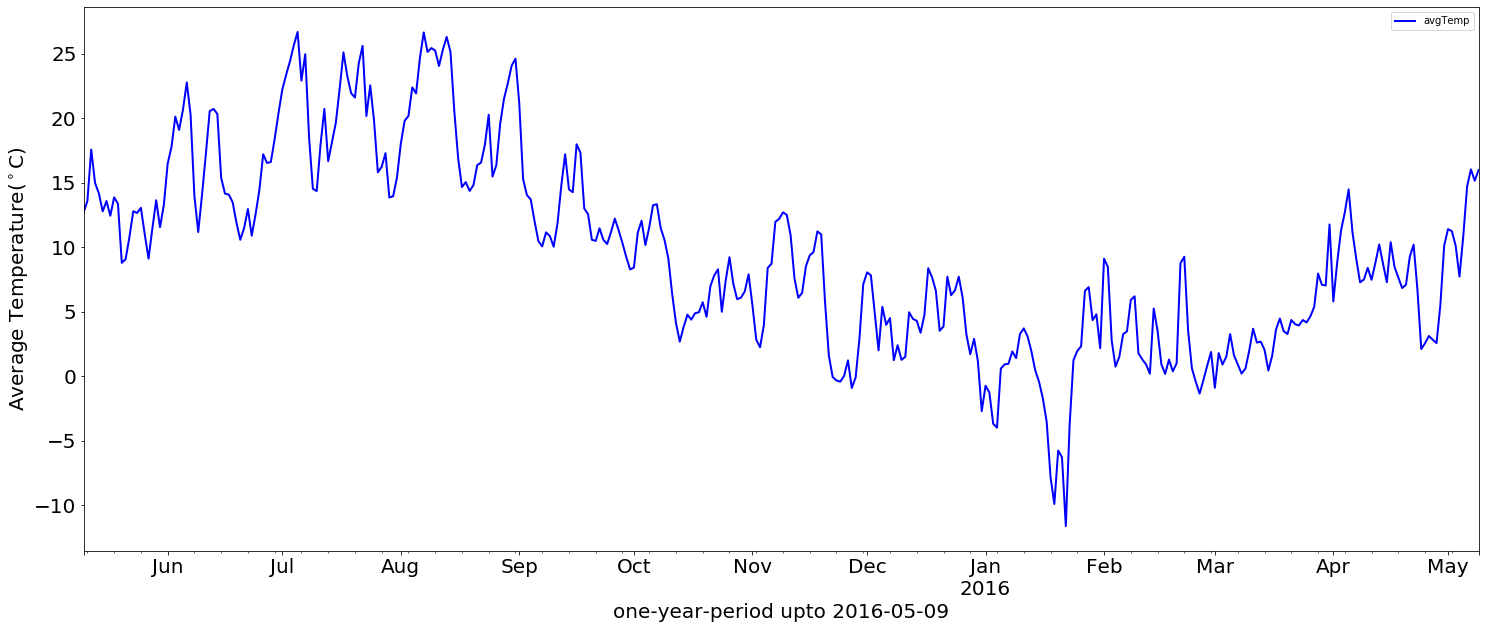

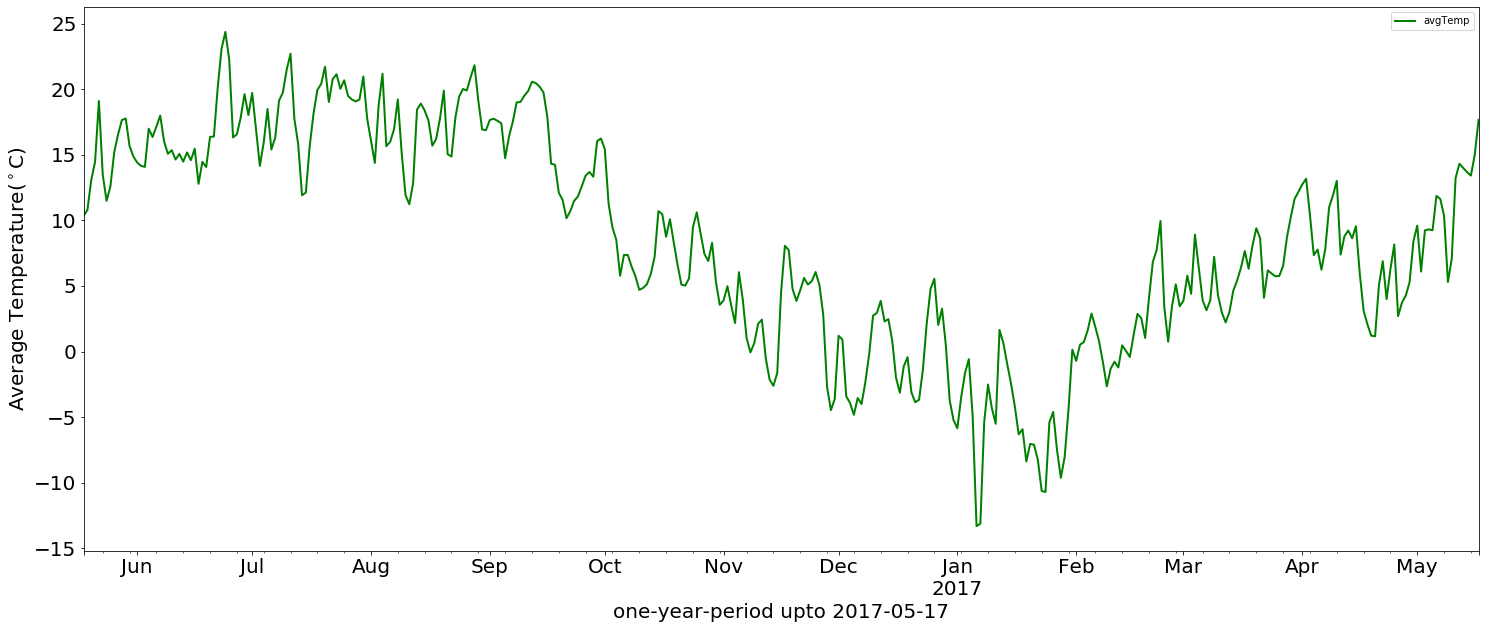

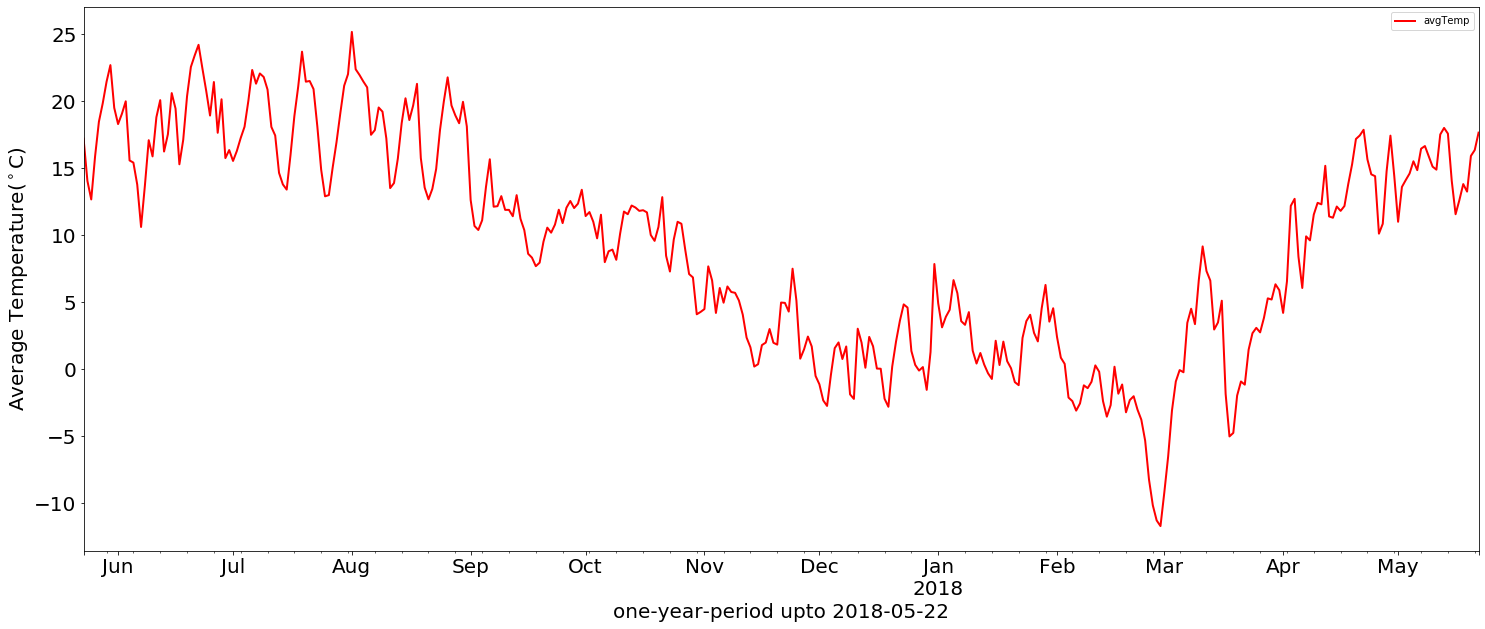

In [53]:
#The days selected are (a) 2016-05-09 (c) 2017-05-17 (e) 2018-05-22
# line plot for avg tempertaure vs time form 2015-05-10 to 2016-05-09
df_date_a.plot(kind='line',x='time',y='avgTemp',color='blue', linewidth = 2,figsize=(25, 10))
plt.xlabel('one-year-period upto 2016-05-09', fontsize=20)
plt.ylabel('Average Temperature($^\circ$C)', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.tick_params(axis='both', which='minor', labelsize=20)
plt.savefig("temperature2016.png")



# line plot for avg tempertaure vs time form 2016-05-18 to 2017-05-17
df_date_c.plot(kind='line',x='time',y='avgTemp',color='green', linewidth = 2,figsize=(25, 10))
plt.xlabel('one-year-period upto 2017-05-17', fontsize=20)
plt.ylabel('Average Temperature($^\circ$C)', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.tick_params(axis='both', which='minor', labelsize=20)
plt.savefig("temperature2017.png")




# line plot for avg tempertaure vs time form 2017-05-23 to 2018-05-22
df_date_e.plot(kind='line',x='time',y='avgTemp',color='red', linewidth = 2,figsize=(25, 10))
plt.xlabel('one-year-period upto 2018-05-22', fontsize=20)
plt.ylabel('Average Temperature($^\circ$C)', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.tick_params(axis='both', which='minor', labelsize=20)
plt.savefig("temperature2018.png")


### **Find avg temperature for 3 years**



The average temperature are:
[9.518818306010923, 8.398287671232879, 9.275171232876712]


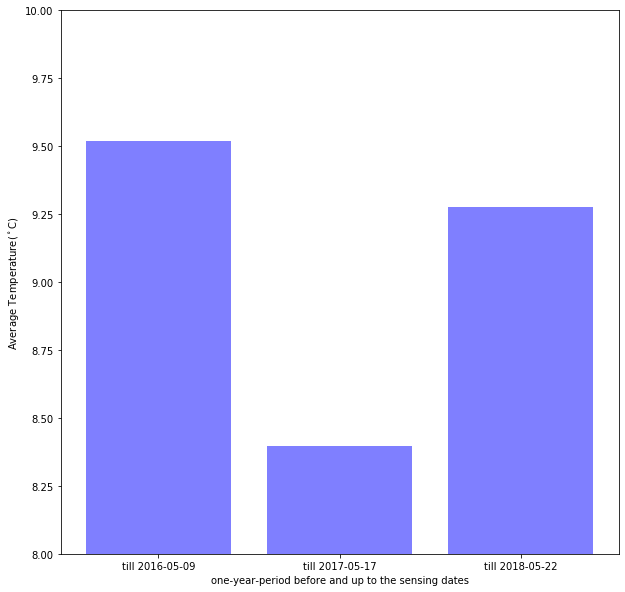

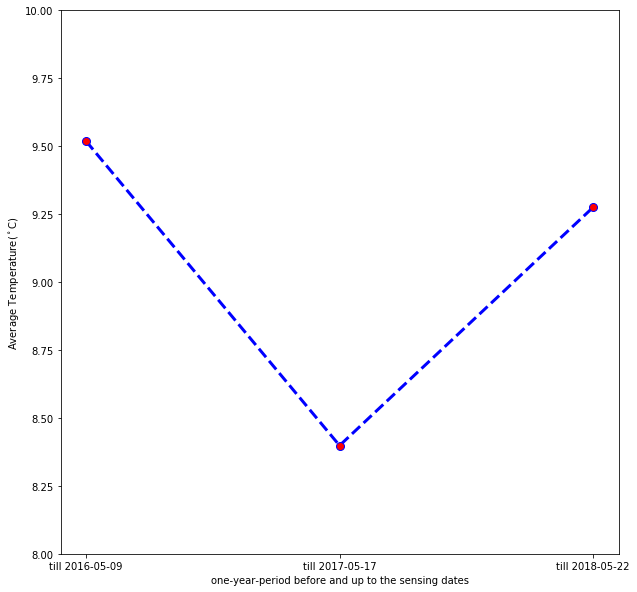

In [65]:
#The days selected are (a) 2016-05-08 (c) 2017-05-26 (e) 2018-05-11
#Displaying average temperature values for month of May and June in the year 2016, 2017, 2018 for 3 dataframe

sensing_date = ['till 2016-05-09', 'till 2017-05-17', 'till 2018-05-22']
avgTemp = [df_date_a['avgTemp'].mean(), df_date_c['avgTemp'].mean(), df_date_e['avgTemp'].mean()]
print('The average temperature are:')
print(avgTemp)

#Bar plot
plt.figure(figsize=(10,10))
plt.bar(sensing_date, avgTemp, color='blue', align='center', alpha=0.5) 
axes = plt.gca()
axes.set_ylim([8,10])
plt.xlabel('one-year-period before and up to the sensing dates')
plt.ylabel('Average Temperature($^\circ$C)')
plt.savefig("bargraph_temp.png")
plt.show()

#Line graph
plt.figure(figsize=(10,10))
plt.plot(sensing_date, avgTemp, color='blue',linestyle='dashed', linewidth = 3, marker='o', markerfacecolor='red', markersize=8)
axes = plt.gca()
axes.set_ylim([8,10])
plt.xlabel('one-year-period before and up to the sensing dates')
plt.ylabel('Average Temperature($^\circ$C)')
plt.savefig("linegraph_temp.png")
plt.show()

## save data

In [55]:
df_all_date = df_date_a.append(df_date_c)
df_all_date = df_all_date.append(df_date_e)
df_all_date.to_csv('average_temperature.csv',index = True)
df_all_date.shape

(1096, 11)

Heat map data


In [56]:
df_all_date.drop_duplicates(keep='first',inplace=True)
df_all_date.shape

(1096, 11)

In [57]:
df_all_date.head()

time  3739  4104  4225  4559  4592  5046  5397  7350  7370  \
38479 2015-05-10  11.9  14.0   NaN  13.0  14.0  11.9  13.2  11.9  11.6   
38480 2015-05-11  13.8  14.1   NaN  12.6  14.2  13.0  14.4  13.6  13.0   
38481 2015-05-12  17.7  18.8   NaN  16.8  18.0  16.8  18.0  18.0  16.4   
38482 2015-05-13  13.5  17.4   NaN  15.5  16.5  13.6  14.4  15.1  13.8   
38483 2015-05-14  13.1  16.2   NaN  14.6  15.8  12.5  13.9  13.9  13.4   

       avgTemp  
38479  12.6875  
38480  13.5875  
38481  17.5625  
38482  14.9750  
38483  14.1750

In [58]:
station_ids = df_all_date.columns.drop(['time','avgTemp']).tolist()

In [59]:
timeseries_list = []
for id in station_ids:
  df_stations = pd.DataFrame()
  df_stations['time'] = df_all_date['time']
  df_stations['latitude'] = dfNRW.loc[id]['latitude']
  df_stations['longitude'] = dfNRW.loc[id]['longitude']
  df_stations['temp'] = df_all_date[id]
  timeseries_list.append(df_stations)

df_timeseries = pd.concat(timeseries_list)
df_timeseries.head()

time  latitude  longitude  temp
38479 2015-05-10   49.4521    12.4365  11.9
38480 2015-05-11   49.4521    12.4365  13.8
38481 2015-05-12   49.4521    12.4365  17.7
38482 2015-05-13   49.4521    12.4365  13.5
38483 2015-05-14   49.4521    12.4365  13.1

In [60]:
df_timeseries.shape

(9864, 4)

In [61]:
df_timeseries.to_csv('timeseries_temperature.csv',index= True)
# from google.colab import files
# files.download('heatmap_temperature.csv')

## data for interpolation


Drop overlapping data

In [62]:
df_all_date.drop_duplicates(keep='first',inplace=True)
df_all_date.shape

(1096, 11)

In [63]:
df_interpolation = df_all_date.transpose()
df_interpolation.drop(['time','avgTemp'],inplace=True)
df_interpolation['avgTemp'] = df_interpolation.mean(axis=1)
df_interpolation = pd.merge(dfNRW,df_interpolation, left_index=True , right_index=True)
df_interpolation[['latitude','longitude','avgTemp']].to_csv('interpolation_temperature.csv',index=True)
# from google.colab import files
# files.download('interpolation_temperature.csv')

In [64]:
sensing_data = [df_date_a,df_date_c,df_date_e]
i = 0
for df in sensing_data:
  df = df.transpose()
  df.drop(['time','avgTemp'],inplace=True)
  df['avgTemp'] = df.mean(axis=1)
  df = pd.merge(dfNRW,df, left_index=True , right_index=True)
  file_name = 'interpolation_temperature_' + sensing_date[i] + '.csv'
  df[['latitude','longitude','avgTemp']].to_csv(file_name,index=True)
  i = i + 1
#   from google.colab import files
#   files.download(file_name)

# Data from NDVI



In [72]:
import pandas as pd

default_qgis_data = {'id':[1,3,7,9,14,15,20,30,34],
                    'MEAN_2016_05_09' : [0.670270574,-0.080382987,0.322618539,0.758542093,0.699984551,0.682241627,0.187858742,0.662919901,0.806486244],
                    'MEAN_2017_05_17' : [0.677615765,-0.010722916,0.332720109,0.756607205,0.664722991,0.720906781,0.677702708,0.654300477,0.118899529],
                    'MEAN_2018_05_22' : [0.829474085,-0.122107018,0.333797374,0.799064601,0.836002852,0.640408245,0.739419655,0.576625959,0.766069018]
                    }

try:
    df_ndvi = pd.read_excel('QGIS_ID.xlsx') # download excel sheet from above mentioned link and update the location 
    print('file found in local directory')
except:
    print('file not found in local directory')
    print('Using default data')
    df_ndvi = pd.DataFrame(default_qgis_data)
    

file not found in local directory
Using default data


### Upload QGIS ndvi data


In [73]:
# from google.colab import files
# uploaded = files.upload()
#df_ndvi = pd.read_excel('QGIS_ID.xlsx')

In [74]:
df_ndvi.head()

id  MEAN_2016_05_09  MEAN_2017_05_17  MEAN_2018_05_22
0   1         0.670271         0.677616         0.829474
1   3        -0.080383        -0.010723        -0.122107
2   7         0.322619         0.332720         0.333797
3   9         0.758542         0.756607         0.799065
4  14         0.699985         0.664723         0.836003

In [83]:
df_ndvi = df_ndvi[['id','MEAN_2016_05_08','MEAN_2017_05_26','MEAN_2018_05_11']]
df_ndvi.head()

KeyError: "['MEAN_2018_05_11', 'MEAN_2017_05_26', 'MEAN_2016_05_08'] not in index"

### adding temperature and cummulative precipitation in ndvi dataframe
#avgTemp = [9.518818306010923, 8.398287671232879, 9.275171232876712]
#cumPrecipt = [636.4035991140644, 781.679069767442, 724.0139534883715]



In [84]:
df_ndvi['AVG_TEMP_2016_05_09'] = 9.52
df_ndvi['AVG_TEMP_2017_05_17'] = 8.40
df_ndvi['AVG_TEMP_2018_05_22'] = 9.27
df_ndvi['CUM_PRECIPIT_2016_05_09'] = 636.40
df_ndvi['CUM_PRECIPIT_2017_05_17'] = 781.68
df_ndvi['CUM_PRECIPIT_2018_05_22'] = 724.01
df_ndvi

id  MEAN_2016_05_09  MEAN_2017_05_17  MEAN_2018_05_22  AVG_TEMP_2016_05_09  \
0   1         0.670271         0.677616         0.829474                 9.52   
1   3        -0.080383        -0.010723        -0.122107                 9.52   
2   7         0.322619         0.332720         0.333797                 9.52   
3   9         0.758542         0.756607         0.799065                 9.52   
4  14         0.699985         0.664723         0.836003                 9.52   
5  15         0.682242         0.720907         0.640408                 9.52   
6  20         0.187859         0.677703         0.739420                 9.52   
7  30         0.662920         0.654300         0.576626                 9.52   
8  34         0.806486         0.118900         0.766069                 9.52   

   AVG_TEMP_2017_05_17  AVG_TEMP_2018_05_22  CUM_PRECIPIT_2016_05_09  \
0                  8.4                 9.27                    636.4   
1                  8.4                 9.27                    636.4   
2                  8.4                 9.27                    636.4   
3                  8.4                 9.27                    636.4   
4                  8.4                 9.27                    636.4   
5                  8.4                 9.27                    636.4   
6                  8.4                 9.27                    636.4   
7                  8.4                 9.27                    636.4   
8                  8.4                 9.27                    636.4   

   CUM_PRECIPIT_2017_05_17  CUM_PRECIPIT_2018_05_22  
0                   781.68                   724.01  
1                   781.68                   724.01  
2                   781.68                   724.01  
3                   781.68                   724.01  
4                   781.68                   724.01  
5                   781.68                   724.01  
6                   781.68                   724.01  
7                   781.68                   724.01  
8                   781.68                   724.01

Create Dataframe for correaltion analysis


In [85]:
def create_dataframe_for_corelation(row):
  data_dic = {}
  dates = ['2016_05_09','2017_05_17','2018_05_22']
  number_of_sensing_dates = 3
  ndvi_start_pos = 1
  while ndvi_start_pos <= number_of_sensing_dates:
    data_dic['id'] = row['id']
    data_dic['meanNDVI'] = row.iloc[ndvi_start_pos]
    data_dic['avgTemp'] = row.iloc[ndvi_start_pos + number_of_sensing_dates ]
    data_dic['cumPrecipt'] = row.iloc[ndvi_start_pos + 2 * number_of_sensing_dates ]
    data_dic['tillDate'] = dates[ndvi_start_pos-1]
    data_list.append(data_dic)
    data_dic = {}
    ndvi_start_pos = ndvi_start_pos + 1

In [86]:
data_list = []
df_ndvi.apply(create_dataframe_for_corelation,axis =1)
df_correlation = pd.DataFrame(data_list)
df_correlation.head()

id  meanNDVI  avgTemp  cumPrecipt    tillDate
0  1.0  0.670271     9.52      636.40  2016_05_09
1  1.0  0.677616     8.40      781.68  2017_05_17
2  1.0  0.829474     9.27      724.01  2018_05_22
3  3.0 -0.080383     9.52      636.40  2016_05_09
4  3.0 -0.010723     8.40      781.68  2017_05_17

### find corelation for each id

In [87]:
uniqueId = df_correlation['id'].unique()

In [88]:
for id in uniqueId:
  print('corelation of the id',id)
  print(df_correlation[df_correlation['id']==id][['meanNDVI','avgTemp','cumPrecipt']].corr(method ='pearson'))

corelation of the id 1.0
            meanNDVI   avgTemp  cumPrecipt
meanNDVI    1.000000  0.265254    0.158630
avgTemp     0.265254  1.000000   -0.909893
cumPrecipt  0.158630 -0.909893    1.000000
corelation of the id 3.0
            meanNDVI   avgTemp  cumPrecipt
meanNDVI    1.000000 -0.828681    0.521815
avgTemp    -0.828681  1.000000   -0.909893
cumPrecipt  0.521815 -0.909893    1.000000
corelation of the id 7.0
            meanNDVI   avgTemp  cumPrecipt
meanNDVI    1.000000 -0.605502    0.881092
avgTemp    -0.605502  1.000000   -0.909893
cumPrecipt  0.881092 -0.909893    1.000000
corelation of the id 9.0
            meanNDVI   avgTemp  cumPrecipt
meanNDVI    1.000000  0.342625    0.077982
avgTemp     0.342625  1.000000   -0.909893
cumPrecipt  0.077982 -0.909893    1.000000
corelation of the id 14.0
            meanNDVI   avgTemp  cumPrecipt
meanNDVI    1.000000  0.484276   -0.077686
avgTemp     0.484276  1.000000   -0.909893
cumPrecipt -0.077686 -0.909893    1.000000
corelation of 

# Plot NDVI with AvgTemp

Scatter plot for meanNDVi with avgTemp and cumprecipt


forest and pasture id are 1, 34

In [89]:
forestIds = [1,3,7,9,14,15,20,30,34]

<Figure size 720x720 with 0 Axes>

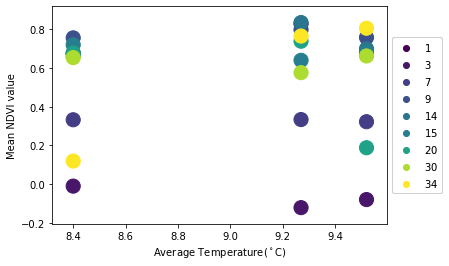

In [90]:
try:
    plt.figure(figsize=(10,10))
    fig, ax = plt.subplots()
    scatter = ax.scatter(x =df_correlation[df_correlation['id'].isin(forestIds)]['avgTemp'],y= df_correlation[df_correlation['id'].isin(forestIds)]['meanNDVI'] ,c = df_correlation[df_correlation['id'].isin(forestIds)]['id'] , s = 200)
    legend1 = ax.legend(*scatter.legend_elements(),loc='center left', bbox_to_anchor=(1, 0.5))
    ax.add_artist(legend1)
    plt.xlabel('Average Temperature($^\circ$C)')
    plt.ylabel('Mean NDVI value')
except:
    plt.scatter(x =df_correlation[df_correlation['id'].isin(forestIds)]['avgTemp'],y= df_correlation[df_correlation['id'].isin(forestIds)]['meanNDVI'] ,c = df_correlation[df_correlation['id'].isin(forestIds)]['id'] , s = 200)
    plt.xlabel('Average Temperature($^\circ$C)')
    plt.ylabel('Mean NDVI value')

# Plot NDVI with Cumulative preciptation

<Figure size 720x720 with 0 Axes>

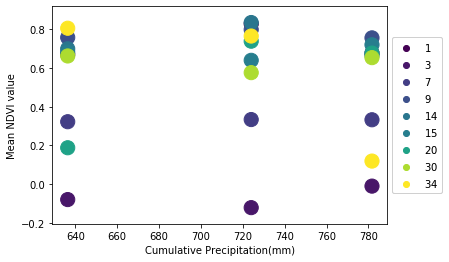

In [91]:
try:
    plt.figure(figsize=(10,10))
    fig, ax = plt.subplots()
    scatter = ax.scatter(x =df_correlation[df_correlation['id'].isin(forestIds)]['cumPrecipt'],y= df_correlation[df_correlation['id'].isin(forestIds)]['meanNDVI'] ,c = df_correlation[df_correlation['id'].isin(forestIds)]['id'] , s = 200)
    legend1 = ax.legend(*scatter.legend_elements(),loc='center left', bbox_to_anchor=(1, 0.5))
    ax.add_artist(legend1)
    plt.xlabel('Cumulative Precipitation(mm)')
    plt.ylabel('Mean NDVI value')

except:
    plt.scatter(x =df_correlation[df_correlation['id'].isin(forestIds)]['cumPrecipt'],y= df_correlation[df_correlation['id'].isin(forestIds)]['meanNDVI'] ,c = df_correlation[df_correlation['id'].isin(forestIds)]['id'] , s = 200)
    plt.xlabel('Cumulative Precipitation(mm)')
    plt.ylabel('Mean NDVI value')

# Average temperature vs Cumulative precpitation


In [92]:
avgTemp = [11.220218579234976, 11.019726027397253, 11.410356164383554]
cumPrecipt = [829.4000000000002, 874.0000000000003, 790.9]


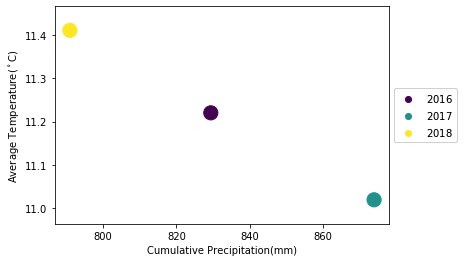

In [93]:
try:
    fig, ax = plt.subplots()
    scatter = ax.scatter(cumPrecipt,avgTemp, c = [2016,2017,2018], s= 200)
    plt.ylabel('Average Temperature($^\circ$C)')
    plt.xlabel('Cumulative Precipitation(mm)')
    legend1 = ax.legend(*scatter.legend_elements(),loc='center left', bbox_to_anchor=(1, 0.5))
    ax.add_artist(legend1)
except:
    plt.scatter(cumPrecipt,avgTemp, c = [2016,2017,2018], s= 200)
    plt.ylabel('Average Temperature($^\circ$C)')
    plt.xlabel('Cumulative Precipitation(mm)')

### Confidence interval of Temperature


In [94]:
import numpy as np
import scipy.stats


def mean_confidence_interval(data, confidence=0.95):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    return m, m-h, m+h

In [95]:
df_all_date.head()

time  3739  4104  4225  4559  4592  5046  5397  7350  7370  \
38479 2015-05-10  11.9  14.0   NaN  13.0  14.0  11.9  13.2  11.9  11.6   
38480 2015-05-11  13.8  14.1   NaN  12.6  14.2  13.0  14.4  13.6  13.0   
38481 2015-05-12  17.7  18.8   NaN  16.8  18.0  16.8  18.0  18.0  16.4   
38482 2015-05-13  13.5  17.4   NaN  15.5  16.5  13.6  14.4  15.1  13.8   
38483 2015-05-14  13.1  16.2   NaN  14.6  15.8  12.5  13.9  13.9  13.4   

       avgTemp  
38479  12.6875  
38480  13.5875  
38481  17.5625  
38482  14.9750  
38483  14.1750

In [96]:
mean_confidence_interval(df_all_date['avgTemp'])

(9.064507299270074, 8.598689621593877, 9.530324976946272)

In [97]:
df_correlation.head()

id  meanNDVI  avgTemp  cumPrecipt    tillDate
0  1.0  0.670271     9.52      636.40  2016_05_09
1  1.0  0.677616     8.40      781.68  2017_05_17
2  1.0  0.829474     9.27      724.01  2018_05_22
3  3.0 -0.080383     9.52      636.40  2016_05_09
4  3.0 -0.010723     8.40      781.68  2017_05_17